# Decisive Results in Chess by Game Length and Opening
Author: Brett Sargent

Email address: basargen@ucsc.edu

Student ID: 1531410

GitHub Repository: https://github.com/bsargent98/ChessEvolution

## Abstract
We aim to explore the likelihood of a chess game having a decisive result based on game length and opening moves. A decisive result is when either player wins the game, as opposed to the game ending in a draw. It is commonly understood that longer chess games are more likely to have decisive results, largely due to the frequency at which professional players agree to a draw before either side has any clear advantage. However, we hypothesized that there eventually comes a tipping point at which longer games will become more likely to end in a draw. We confirmed this hypothesis, finding that games which last 39 moves are most likely to have a decisive result and after that, longer games become more likely to end in a draw.

We also explored how this relationship changes when we condition on opening moves. We first compared king's pawn openings against all other openings, since king's pawn (e4) openings occur in about half of the games in our dataset. We found that, while king's pawn is overall less likely to end in a draw, both e4 and non-e4 exhibit the same 'tipping point' at 39 moves. We also analyzed all possible opening moves, and saw that same tipping point in nearly all of them. However, analyzing all openings isn't necessarily informative since many openings are rarely used. In fact, of the twenty possible opening moves, the four most common are used in over 97% of games in our dataset. Opening moves aside from these four are practically never used in higher-level play. In all four of these openings, we see the same tipping point of likelihood of a decisive outcome as we mentioned earlier.

To make a more meaningful exploration of openings, we also explored this tipping point when conditioning on opening classification. These classifications are determined by the first few moves by each player, not just the first move by white. Openings are classified as one of: flank opening, semi-open game, open game, closed game, and Indian defenses. We used the opening codes according to the Encyclopedia of Chess Openings to determine each game's classification. All classifications have the same tipping point, but we also found another interesting relationship. Open games are far more likely to have a decisive result than any other classificaiton, followed by semi-open games. Games where black employs an Indian defense are the most likely to end in a draw. This may indicate that Indian defenses (part of the hypermodernist school) are the most effective at reducing white's inherent advantage.

## Questions
1. Do longer games necessarily result in more decisive results, or is there a tipping point where longer games are more likely to end in a draw? 
It is commonly understood that many short games end in a draw, and longer games are more likely to have decisive results. We want to know whether than association is universal or whether there is point where longer games once again become more likely to end in a draw. 


2. How does this change when we condition on opening move?
We want to know whether this 'tipping point' is affected by the first move of the game. That is, we wish to know if this tipping point is different for different openings and/or if the overall proportions of draws differ depending on the opening move.


3. How does this change when we condition on opening classifcation? 
To provide an analysis of openings and game lengths that is more relevant to common gameplay, we are extending the second question to opening classifications. This is because there are only four opening moves that are played in practice and the opening move doesn't necessarily determine if the players will tend towards tactical or positional play types.

## Methods and Results
To answer our questions, we need to scrape our dataset from the web and then perform a number of wrangling, analysis, and visualization tasks.

### Web Scraping
We begin by scraping all of our data from the internet. We begin by navigating to this page:

https://chess-db.com/public/execute.jsp?age=99&countries=all&sex=a&start=0

We then download each PGN (Portable Game Notation) file and then navigate to the next page, where we do the same. We completed this task for the first 1,000 pages, gathering a total of 138,642 PGN files.



#### IMPORTANT NOTE: Only run the code in the cell below if you are willing to download ~10GB of PGN files. This may take some time. Also, the code will not work if you do not replace 'email' and 'password' on line 9 with the login information for an account at chess-db.com. If you run the code without logging in, you will be able to download only a handful of PGN files before you exceed your limit on the site. Once the limit is exceeded the files will still download, but they will simply say you need to make an account, rather than containing game information. 

In [ ]:
#Import libraries
import os
import requests
from bs4 import BeautifulSoup
import mechanize

#Set up requests session
login_url = 'https://chess-db.com/public/login.jsp?'
login_data = dict(username='email', password='password') #NEED TO FILL IN EMAIL AND PASSWORD TO RUN
session = requests.session()

r = session.post(login_url, data=login_data)

#Given an integer, scrape the page starting at that player number
#Pages have 1000 players, so we increment start by 1,000 each time we want a new page
def scrape_page(start): 
    #Get the page
    page = session.get('https://chess-db.com/public/execute.jsp?age=99&countries=all&sex=a&start={}'.format(start))
    #Parse with BeautifulSoup
    soup = BeautifulSoup(page.content, 'html.parser')
    url = 'https://chess-db.com/public/' #start of URL for a download file

    os.mkdir("data/pgn_by_id/" + str(round(start/1000))) #Make a new directory for each page
    
    links = soup.find_all('a') #Find all links on the page
    
    cnt = 0
    n = 1000
    for link in links: #For each link on the page
        if 'download.jsp?id=' in link['href']: #If it's the type of link we're looking for
            cnt = cnt + 1 #Increase count of files
            url_full = url + link['href'] #Make full URL of download link
            id = link['href'][16:] #Get the ID of the player, which we use for naming the PGN files
                
            #Request the PGN
            print('Requesting page at {}'.format(url_full))
            r = session.get(url_full, allow_redirects=True)
                
            #Write PGN to disk
            print('Got page at {}. Writing...'.format(url_full))
            open('data/pgn_by_id/{}/{}.pgn'.format(round(start / 1000), id), 'wb').write(r.content)
    
            print('Saved page at {} as /data/pgn_by_id/{}.pgn'.format(url_full, id))
            print('{}/{}'.format(cnt, n))
            print('\n\n=================\n\n\n')
			
#Do this for 1000 pages
start = 0
stop = 100000

#Loop to run function
i = start
while i < stop:
    scrape_page(i)
    i = i + 1000

### Data Wrangling
##### Convert PGN files to master CSV
Since the downloaded files are fairly messy, unusable by Pandas, larger than necessary, and contain two of each game due to each player of each game having a record of the game in their file, we wish to wrangle the data into a more compact and accessible format. To do this, we will copy all games into a master CSV file where each row is a game and each column is a line of that game in a PGN file. 
That is, our columns are: event,site,date,round,white,black,eco,whiteElo,blackElo,moves,result

For this task, we use the following code. 


#### IMPORTANT NOTE: The following cell will only work if you have ran the above cell. Also, be aware that it may take several hours to run this code.  

In [ ]:
import os

rootdir = 'data/pgn_by_id/' #The directory where we saved the PGN files

game_set = set() #Use a set because duplicate games will be automatically filtered out
games_read = 0 #The total number of games read
games_inset = 0 #The number of games in set; used to check that we removed half of games (duplicates)

#Iterate through each PGN file
for subdir, dirs, files in os.walk(rootdir):
    for dir in dirs: #For each directory in the main directory
        for subdir2, dirs2, files2 in os.walk(rootdir + dir): 
            for file in files2: #for each file in the directory 
                path = rootdir + dir + '/' + file #Get the path of the PGN file
                with open(path, 'r') as fp: #Open the PGN file for reading
                    line = fp.readline() #Read in a line
                    while line: #Read through the file
                        if line[:6] == '[Event': #If we've reached a new game (Event is the first line of a game)
                            games_read = games_read + 1 #Add to count of games read
                        
                            line = line.strip() #Strip excess whitespace
                            event = line[8:-2] #Get the event
                            
                            line = fp.readline().strip() #Next line
                            site = line[7:-2] #Get the site of the event
                            
                            line = fp.readline().strip() #Next line
                            date = line[7:-2] #Get the date of the event
                            
                            line = fp.readline().strip() #Next line
                            Round = line[8:-2] #Get the round of the event
                            
                            line = fp.readline().strip() #Next line
                            white = line[8:-2] #Get the white player
                            
                            line = fp.readline().strip() #Next line
                            black = line[8:-2] #Get the black player
                            
                            line = fp.readline().strip() #Next line
                            eco = line[6:-2] #Get ECO opening code
                            
                            line = fp.readline().strip() #Next line
                            whiteElo = line[11:-2] #Get elo of white player
                            
                            line = fp.readline().strip() #Next line
                            blackElo = line[11:-2] #Get elo of black player
                            
                            line = fp.readline() #skip line
                            line = fp.readline() #skip line
                            
                            line = fp.readline().strip() #Next line
                            moves = line #get the list of moves
                            
                            line = fp.readline() #skip line
                            
                            line = fp.readline().strip() #Next line
                            result = line #Get the result
                            print(result) #Print result to make sure everything lines up
                            
                            game = (event, site, date, Round, white, black, eco, whiteElo, blackElo, moves, result) #Make game tuple
                            game_set.add(game) #Add game to set
                            
                        line = fp.readline() #Go to the next line

games_inset = len(game_set) #Number of games in the set

print("Games read: {}".format(games_read))
print("Games in set: {}".format(games_inset))

with open('games_list.csv', 'w') as out:
    for game in game_set:
        for i in range(len(game) - 1):
            out.write('{},'.format(game[i]))
        out.write('{}\n'.format(game[-1]))

##### Extract outcome distributions for every game length
The following code will extract the total number of games of each outcome of each length (in number of moves) and store those distributions in a CSV file, 'simple_dists.csv'. For this code to work, you need to have ran the previous cells and have 'data/game_list.csv'. The generated CSV file will be used for length-outcome analysis on the entire dataset.

In [ ]:
#open 'data/game_list.csv' for reading
#iterate through all games. For each game:
    #Record result and number of moves
    #use dict where key is length in moves and value is list of dim 3
        #First element is #of white wins for games of that length, 2nd is # of black wins, third, is # of draws

#For each key in dict:
    #Find proportion of each result and store in list where i-th element is distribution for i-length games
#Save all of these distributions in a csv so we don't have to repeat computation to see/plot the results again

import math
import time


dists = {} #Directory where key is game length and value is dim-4 vector [white,black,draw,unknown] of outcome counts

t1 = time.time() 
with open('data/game_list.csv', 'r') as fp: #Open master CSV
    line = fp.readline() #Skip header
    line = fp.readline() #Get first row

    while line: #For each row
        data = line.split(',') #Split into columns
        
        moves = data[-2].split() #Get the list of moves
        
        length = math.ceil(len(moves)/3) #Get the length of the game
        
        result = data[-1].strip() #Get the result
        
        if result == '1-0': #White wins
            print('white')
            if length not in dists: #If first game of this length, make a new vector
                dists[length] = [1, 0, 0, 0] #1 win for white, no other counts yet
            else: #If length seen before, update vector
                dists[length][0] = dists[length][0] + 1
                
        elif result == '0-1': #Black wins
            print('black')
            if length not in dists:
                dists[length] = [0, 1, 0, 0]
            else:
                dists[length][1] = dists[length][1] + 1

        elif result == '1/2-1/2': #Draw
            print('draw')
            if length not in dists:
                dists[length] = [0, 0, 1, 0]
            else:
                dists[length][2] = dists[length][2] + 1
                
        elif result == '*': #Unknown outcome
            print('unknown')
            if length not in dists:
                dists[length] = [0, 0, 0, 1]
            else:
                dists[length][3] = dists[length][3] + 1
                
        else: #If something else comes up as result, throw an error
            print('ERROR! UNKNOWN RESULT: {}'.format(result)) 
            exit(0)

        line = fp.readline() #Get next line
t2 = time.time()

print('Time to count game results: {}. Writing...'.format(t2-t1))

t3 = time.time()
with open('data/simple_dists.csv', 'w') as fp: #Write to file
    fp.write('length,white,black,draw,unknown\n')
    for key in dists: #For each length, make a new row
        fp.write('{},{},{},{},{}\n'.format(key, dists[key][0], dists[key][1], dists[key][2], dists[key][3]))
t4 = time.time()

print('Time to write: {}. Thank you for wrangling with us today.'.format(t4-t3))

##### Extract outcome distributions for e4 (king's pawn) and non-e4 games
The following code will extract the total number of games of each outcome of each length (in number of moves) and store those distributions in two CSV files, 'e4_dists.csv' and 'not_e4_dists.csv'. For this code to work, you need to have ran the previous cells and have 'data/game_list.csv'. The generated CSV files will be used for length-outcome analysis between e4 games and other games.

In [ ]:
#open 'data/game_list.csv' for reading
#iterate through all games. For each game:
    #Record result and number of moves
    #use dict where key is length in moves and value is list of dim 3
        #First element is #of white wins for games of that length, 2nd is # of black wins, third, is # of draws

#For each key in dict:
    #Find proportion of each result and store in list where i-th element is distribution for i-length games
#Save all of these distributions in a csv so we don't have to repeat computation to see/plot the results again

#Plot that shit and check for a 'drop-off' point where games are more likely to end in draw

import math
import time


e4_dists = {} #Like the above dict, but only for e4 games
not_e4_dists = {} #Like dict in above cell, but only for non-e4 games

e4_games = 0 
not_e4_games = 0

e4_diff_total = 0
e4_diff_abs = 0
not_e4_diff_total = 0
not_e4_diff_abs = 0

t1 = time.time()
with open('data/game_list.csv', 'r') as fp:
    line = fp.readline()
    line = fp.readline()
    
    while line: #For each line
        #All of this logic is identical to the above cell, but e4 and non-e4 games are split into separate dicts
        data = line.split(',')
        
        moves = data[-2].split()
        
        length = math.ceil(len(moves)/3)
        
        if len(moves) < 2:
            line = fp.readline()
            continue
        
        result = data[-1].strip()
        
        #For evaluating elo; can be ignored
        whiteElo = int(data[-4])
        blackElo = int(data[-3])
        eloDiff = whiteElo - blackElo
        absEloDiff = abs(whiteElo - blackElo)
        
        
        if result == '1-0':
            print('white') #white wins
            if moves[1] == 'e4': #If game begins with e4
                e4_games = e4_games + 1 #elo, ignore
                e4_diff_total = e4_diff_total + eloDiff #elo, ignore
                e4_diff_abs = e4_diff_abs + absEloDiff #elo, ignore
                
                print('e4')
                if length not in e4_dists:
                    e4_dists[length] = [1, 0, 0, 0]
                else:
                    e4_dists[length][0] = e4_dists[length][0] + 1
            else: #If game not e4
                not_e4_games = not_e4_games + 1
                not_e4_diff_total = not_e4_diff_total + eloDiff
                not_e4_diff_abs = not_e4_diff_abs + absEloDiff
                
                print('not e4')
                if length not in not_e4_dists:
                    not_e4_dists[length] = [1, 0, 0, 0]
                else:
                    not_e4_dists[length][0] = not_e4_dists[length][0] + 1
                
        elif result == '0-1':
            print('black')
            if moves[1] == 'e4':
                e4_games = e4_games + 1
                e4_diff_total = e4_diff_total + eloDiff
                e4_diff_abs = e4_diff_abs + absEloDiff
            
                print('e4')
                if length not in e4_dists:
                    e4_dists[length] = [0, 1, 0, 0]
                else:
                    e4_dists[length][1] = e4_dists[length][1] + 1
            else:
                not_e4_games = not_e4_games + 1
                not_e4_diff_total = not_e4_diff_total + eloDiff
                not_e4_diff_abs = not_e4_diff_abs + absEloDiff
                
                print('not e4')
                if length not in not_e4_dists:
                    not_e4_dists[length] = [0, 1, 0, 0]
                else:
                    not_e4_dists[length][1] = not_e4_dists[length][1] + 1
                
        elif result == '1/2-1/2':
            print('draw')
            if moves[1] == 'e4':
                e4_games = e4_games + 1
                e4_diff_total = e4_diff_total + eloDiff
                e4_diff_abs = e4_diff_abs + absEloDiff
                
                print('e4')
                if length not in e4_dists:
                    e4_dists[length] = [0, 0, 1, 0]
                else:
                    e4_dists[length][2] = e4_dists[length][2] + 1
            else:
                not_e4_games = not_e4_games + 1
                not_e4_diff_total = not_e4_diff_total + eloDiff
                not_e4_diff_abs = not_e4_diff_abs + absEloDiff
                
                print('not e4')
                if length not in not_e4_dists:
                    not_e4_dists[length] = [0, 0, 1, 0]
                else:
                    not_e4_dists[length][2] = not_e4_dists[length][2] + 1
                
        elif result == '*':
            print('unknown')
            if moves[1] == 'e4':
                e4_games = e4_games + 1
                e4_diff_total = e4_diff_total + eloDiff
                e4_diff_abs = e4_diff_abs + absEloDiff
                
                print('e4')
                if length not in e4_dists:
                    e4_dists[length] = [0, 0, 0, 1]
                else:
                    e4_dists[length][3] = e4_dists[length][3] + 1
            else:
                not_e4_games = not_e4_games + 1
                not_e4_diff_total = not_e4_diff_total + eloDiff
                not_e4_diff_abs = not_e4_diff_abs + absEloDiff
                
                print('not e4')
                if length not in not_e4_dists:
                    not_e4_dists[length] = [0, 0, 0, 1]
                else:
                    not_e4_dists[length][3] = not_e4_dists[length][3] + 1
                
        else:
            print('ERROR! UNKNOWN RESULT: {}'.format(result))
            exit(0)

        line = fp.readline()
t2 = time.time()

print('Time to count game results: {}. Writing...'.format(t2-t1))
            
t3 = time.time()
#Write e4 dists to file
with open('data/e4_dists.csv', 'w') as fp: 
    fp.write('length,white,black,draw,unknown\n')
    for key in e4_dists:
        fp.write('{},{},{},{},{}\n'.format(key, e4_dists[key][0], e4_dists[key][1], e4_dists[key][2], e4_dists[key][3]))
        
#Write not-e4 dists to file
with open('data/not_e4_dists.csv', 'w') as fp:
    fp.write('length,white,black,draw,unknown\n')
    for key in not_e4_dists:
        fp.write('{},{},{},{},{}\n'.format(key, not_e4_dists[key][0], not_e4_dists[key][1], not_e4_dists[key][2], not_e4_dists[key][3]))
        
t4 = time.time()
        
print('Time to write: {}'.format(t4-t3))

##### Extract outcome distributions for all openings
The following code will extract the total number of games of each outcome of each length (in number of moves) and store those distributions in twenty CSV files, one for each opening move. The logic is identical to the above cells, but we use dict of dicts to track out distributions for all lengths and all opening moves. This also generates a file, 

'avg_elo_diff_by_opening.txt',

which shows average elo differential for each opening move. This file isn't of relevance to our investigation, but may be of interest to the reader.

In [ ]:
#import libraries
import math
import time

#strings of top 20 openings
openings = ['e4','d4','c4','Nf3','g3','b3','f4','Nc3','b4','e3','d3','c3','a3','g4','h3','h4','Nh3','a4','f3','Na3']

#dict where key is opening move and value is list [int,int,dict]
#data[open][0] is total number of games opening with open
#data[open][1] is sum of white-black elo differentials for games where opening is open
#data[open][2] is dict where keys are game lengths in move count and values are [int,int,int,int] 
    #The 4-dimensional list above is total number of each outcome by length and opening => [white,black,draw,unknown]
    #Ex: data[open][2][length][0] is the count of games of where opening move is open, number of moves is length, and white won
data = {}

t1 = time.time()
with open('data/game_list.csv', 'r') as fp: #for each game
    line = fp.readline() #read and ignore header row
    line = fp.readline()#read first game
    
    while line: #while end of file isn't reached
        row = line.split(',') #split on comma to get columns
        
        moves = row[-2].split() #get the whitespace-delimited list of moves in algebraic notation
        
        length = math.ceil(len(moves)/3) #get the number of moves
        
        #if there aren't any moves, skip this game
        if len(moves) < 2: 
            line = fp.readline()
            continue
        
        #get result string, one of '1-0', '0-1', '1/2-1/2', '*'
        result = row[-1].strip()
        
        #get elos and calculate differential
        whiteElo = int(row[-4])
        blackElo = int(row[-3])
        eloDiff = whiteElo - blackElo
        
        opening = moves[1] #get the string for the opening move
        
        #if white won
        if result == '1-0':
            print('white')
            #if the opening isn't in the top 20 most common, set it to 'other'
            if opening not in openings:
                opening = 'other'
            #if we haven't seen this opening before, add a dictionary entry for it
            if opening not in data:
                data[opening] = [1, eloDiff, {}] #since we haven't seen it before, game count is one, total elo diff is eloDiff, and distribution dict is empty
                data[opening][2][length] = [1, 0, 0, 0] #add the first entry to the distribution dict (result = '1-0' so white won)
            #if we have seen it, update the dictionary entry
            else:
                data[opening][0] = data[opening][0] + 1 #increment the game count by 1
                data[opening][1] = data[opening][1] + eloDiff #add eloDiff to the total elo differntial for this move and length
                #if we haven't seen this length with this opening, make a new dist dict entry for this length
                if length not in data[opening][2]:
                    data[opening][2][length] = [1, 0, 0, 0]
                #if we have seen this length, update the distribution dict entry for this length
                else:
                    data[opening][2][length][0] = data[opening][2][length][0] + 1 #we use the 0th entry for this distribution dict since white won

        #if black won; look at comments for white because it's the same
        elif result == '0-1':
            print('black')
            if opening not in openings:
                opening = 'other'
                
            if opening not in data:
                dist_dict = {}
                data[opening] = [1, eloDiff, dist_dict]
                data[opening][2][length] = [0, 1, 0, 0]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 1, 0, 0]
                else:
                    data[opening][2][length][1] = data[opening][2][length][1] + 1
                
        #if game was a draw; look at comments for white for more info
        elif result == '1/2-1/2':
            print('draw')
            if opening not in openings:
                opening = 'other'
                
            if opening not in data:
                data[opening] = [1, eloDiff, {}]
                data[opening][2][length] = [0, 0, 1, 0]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 0, 1, 0]
                else:
                    data[opening][2][length][2] = data[opening][2][length][2] + 1

        #if outcome was unknown; check previous comments for info
        elif result == '*':
            print('white')
            if opening not in openings:
                opening = 'other'

            if opening not in data:
                data[opening] = [1, eloDiff, {}]
                data[opening][2][length] = [0, 0, 0, 1]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 0, 0, 1]
                else:
                    data[opening][2][length][3] = data[opening][2][length][3] + 1
                
        #if something else is in the result column, throw an error
        else:
            print('ERROR! UNKNOWN RESULT: {}'.format(result))
            exit(0)

        #read in the next game
        line = fp.readline()
t2 = time.time()

print('Time to count game results: {}. Writing...'.format(t2-t1)) #print runtime to console
            
t3 = time.time()
#for each opening, make a distribution file and add to elo file
for opening in openings:
    path = 'data/{}_dists.csv'.format(opening)
    with open(path, 'w') as fp: #make new csv for length/outcome distributions for this opening
        fp.write('length,white,black,draw,unknown\n') #header row
        #for each length in the distribution dict for this opening
        for key in data[opening][2]:
            fp.write('{},{},{},{},{}\n'.format(key, data[opening][2][key][0], data[opening][2][key][1], data[opening][2][key][2], data[opening][2][key][3])) #write outcome counts
            
    with open('data/avg_elo_diff_by_opening.txt', 'a') as fp: #append to the average elo diff file
        fp.write('{}: {} total elo differential over {} games; {} is average differential'.format(opening, data[opening][1], data[opening][0], data[opening][1]/data[opening][0])) #add a new line for this opening
t4 = time.time()
        
print('Time to write: {}. Thank you for using this shitty code.'.format(t4-t3)) #print writing time to console

##### Extract outcome distributions for opening classifications
The following code will extract the total number of games of each outcome classification of each length (in number of moves) and store those distributions in five CSV files, one for each opening classification. The logic is identical to the above cell, but we replace opening move with opening classification. We added a function, 'get_opening(elo)', which accepts as input an ECO opening code and returns the opening classification. This allows us to keep this cell nearly identical to the one above. This also generates a file, 

'avg_elo_diff_by_class.txt',

which shows average elo differential for each opening classification. This file isn't of relevance to our investigation, but may be of interest to the reader.

In [ ]:
#import libraries
import math
import time

#strings of top 20 openings
openings = ['flank', 'open', 'sopen', 'closed', 'indian']

def get_opening(eco): #return an element of openings given an ECO code
    if eco[0] == 'A': #volume A is flank openings
        return 'flank'
    elif eco[0] == 'B': #volume B is semi-open other than French defense
        return 'sopen'
    elif eco[0] == 'C': #volume C is open and French defense
        if int(eco[1:]) < 20: #C00-C19 are French defense
            return 'sopen'
        else: #C20-C99 are open games
            return 'open'
    elif eco[0] == 'D': #volume D is closed and semi-closed
        if int(eco[1:]) < 70: #D00-D69 are closed games (double queen pawn)
            return 'closed'
        else: #D70-D99 are Grunfeld defense (semi-closed, Indian)
            return 'indian'
    else: #volume E is Indian other than Grunfeld
        return 'indian'
        

#dict where key is opening move and value is list [int,int,dict]
#data[open][0] is total number of games opening with open
#data[open][1] is sum of white-black elo differentials for games where opening is open
#data[open][2] is dict where keys are game lengths in move count and values are [int,int,int,int] 
    #The 4-dimensional list above is total number of each outcome by length and opening => [white,black,draw,unknown]
    #Ex: data[open][2][length][0] is the count of games of where opening move is open, number of moves is length, and white won
data = {}

t1 = time.time()
with open('data/game_list.csv', 'r') as fp: #for each game
    line = fp.readline() #read and ignore header row
    line = fp.readline()#read first game

    while line: #while end of file isn't reached
        row = line.split(',') #split on comma to get columns
        
        moves = row[-2].split() #get the whitespace-delimited list of moves in algebraic notation
        
        length = math.ceil(len(moves)/3) #get the number of moves
        
        eco = row[-5]
        opening = get_opening(eco)
        
        print(eco)
        
        #if there aren't any moves, skip this game
        if len(moves) < 2: 
            line = fp.readline()
            continue
        
        #get result string, one of '1-0', '0-1', '1/2-1/2', '*'
        result = row[-1].strip()
        
        #get elos and calculate differential
        whiteElo = int(row[-4])
        blackElo = int(row[-3])
        eloDiff = whiteElo - blackElo
        
        #if white won
        if result == '1-0':
            print('white')
            #if the opening isn't in the top 20 most common, set it to 'other'
            if opening not in openings:
                opening = 'other'
            #if we haven't seen this opening before, add a dictionary entry for it
            if opening not in data:
                data[opening] = [1, eloDiff, {}] #since we haven't seen it before, game count is one, total elo diff is eloDiff, and distribution dict is empty
                data[opening][2][length] = [1, 0, 0, 0] #add the first entry to the distribution dict (result = '1-0' so white won)
            #if we have seen it, update the dictionary entry
            else:
                data[opening][0] = data[opening][0] + 1 #increment the game count by 1
                data[opening][1] = data[opening][1] + eloDiff #add eloDiff to the total elo differntial for this move and length
                #if we haven't seen this length with this opening, make a new dist dict entry for this length
                if length not in data[opening][2]:
                    data[opening][2][length] = [1, 0, 0, 0]
                #if we have seen this length, update the distribution dict entry for this length
                else:
                    data[opening][2][length][0] = data[opening][2][length][0] + 1 #we use the 0th entry for this distribution dict since white won
                
        #if black won; look at comments for white because it's the same
        elif result == '0-1':
            print('black')
            if opening not in openings:
                opening = 'other'
                
            if opening not in data:
                dist_dict = {}
                data[opening] = [1, eloDiff, dist_dict]
                data[opening][2][length] = [0, 1, 0, 0]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 1, 0, 0]
                else:
                    data[opening][2][length][1] = data[opening][2][length][1] + 1
                
        #if game was a draw; look at comments for white for more info
        elif result == '1/2-1/2':
            print('draw')
            if opening not in openings:
                opening = 'other'
                
            if opening not in data:
                data[opening] = [1, eloDiff, {}]
                data[opening][2][length] = [0, 0, 1, 0]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 0, 1, 0]
                else:
                    data[opening][2][length][2] = data[opening][2][length][2] + 1
                
        #if outcome was unknown; check previous comments for info
        elif result == '*':
            print('white')
            if opening not in openings:
                opening = 'other'

            if opening not in data:
                data[opening] = [1, eloDiff, {}]
                data[opening][2][length] = [0, 0, 0, 1]
            else:
                data[opening][0] = data[opening][0] + 1
                data[opening][1] = data[opening][1] + eloDiff
                if length not in data[opening][2]:
                    data[opening][2][length] = [0, 0, 0, 1]
                else:
                    data[opening][2][length][3] = data[opening][2][length][3] + 1
                
        #if something else is in the result column, throw an error
        else:
            print('ERROR! UNKNOWN RESULT: {}'.format(result))
            exit(0)
    
        #read in the next game
        line = fp.readline()
t2 = time.time()

print('Time to count game results: {}. Writing...'.format(t2-t1)) #print runtime to console
            
t3 = time.time()
#for each opening, make a distribution file and add to elo file
for opening in openings:
    path = 'data/{}_dists.csv'.format(opening)
    with open(path, 'w') as fp: #make new csv for length/outcome distributions for this opening
        fp.write('length,white,black,draw,unknown\n') #header row
        #for each length in the distribution dict for this opening
        for key in data[opening][2]:
            fp.write('{},{},{},{},{}\n'.format(key, data[opening][2][key][0], data[opening][2][key][1], data[opening][2][key][2], data[opening][2][key][3])) #write outcome counts
            
    with open('data/avg_elo_diff_by_class.txt', 'a') as fp: #append to the average elo diff file
        fp.write('{}: {} total elo differential over {} games; {} is average differential\n'.format(opening, data[opening][1], data[opening][0], data[opening][1]/data[opening][0])) #add a new line for this opening
t4 = time.time()
        
print('Time to write: {}. Thank you for using this shitty code.'.format(t4-t3)) #print writing time to console

### Analysis and Visualizations
With our data now organized, we can begin to explore our questions. We begin by exploring the distributions of the entire dataset with the goal of finding a 'tipping point' after which games once again become more likely to end in a draw. We then direct our investiagation towards how our results change when we condition on opening move and opening classification.

##### Read in outcome distributions of all games
We read in 'simple_dists.csv', select a region to analyze, and show that our region represents the dataset

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Read in the outcome distributions, sort them by length and add a column for total game count
simple_dists = pd.read_csv('data/dists/simple_dists.csv')
sd = simple_dists.sort_values(by='length')
sd['total'] = sd['white'] + sd['black'] + sd['draw']
print('Total number of games in dataset: {}'.format(sum(sd['total'])))

#Look at a specific region to cut out outliers
#We will examine games between one move and 100 moves
x1 = 1 #start of region
x2 = 100 #end of region
region = sd.loc[sd['length'] >= x1]
region = region.loc[region['length'] <= x2]

#As evidence that this region is not excluding large portions of data, 
#we compute the percentage of games which are in this region
print('Percentage of dataset within region: {}%'.format(round(100*sum(region['total'])/sum(sd['total']), 2)))

Total number of games in dataset: 5592895
Percentage of dataset within region: 99.68%


##### Basic game statistics
Here we display some basic statistics about our dataset to give the reader a better idea of the data we're working with. We find that the mean game length is just over 39 and we computed the standard deviation to be around 16. We analyzed the standard deviation because the distribution of game length appears roughly Gaussian.

In [2]:
import math
mean = round(sum(sd['total'] * sd['length'])/sum(sd['total']), 4) #the mean
std = round(math.sqrt((sum(sd['total'] * (sd['length'] - mean)**2)) / sum(sd['total'])), 4)

print('Mean game length in number of moves: {}'.format(mean))
print('Standard deviation: {}'.format(std))
print('Proportion of games won by white: {}'.format(round(sum(sd['white'])/sum(sd['total']), 4)))
print('Proportion of games won by black: {}'.format(round(sum(sd['black'])/sum(sd['total']), 4)))
print('Proportion of games ending in draw: {}'.format(round(sum(sd['draw'])/sum(sd['total']), 4)))

Mean game length in number of moves: 39.3141
Standard deviation: 16.1981
Proportion of games won by white: 0.3889
Proportion of games won by black: 0.3148
Proportion of games ending in draw: 0.2963


##### Plot number of games and proportion of games ending in draw for each length in our region
We make these plots to show the distribution of game lengths and the proportion of games of each length which end in a draw. We add the second-degree polynomial of best fit to the proportion of draws (dashed black line) to show the tipping point.

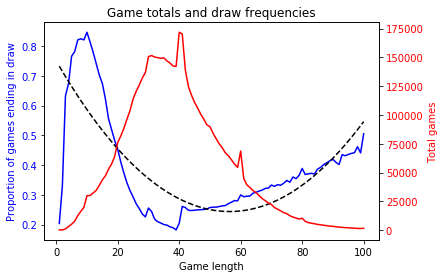

In [3]:
fig, ax1 = plt.subplots() #Make a figure
ax2 = ax1.twinx() #We use two y-axes
ax1.set_title('Game totals and draw frequencies')

region_draw_prop = region['draw']/(region['total']) #Proportion of draws for each length

#Polynomial of best fit (second-degree)
coef = np.polyfit(region['length'],region_draw_prop,2)
poly2d_fn = np.poly1d(coef)

#Plot proportion of draws and label first y-axis
ax1.plot(region['length'], region_draw_prop, color='blue')
ax1.set_ylabel('Proportion of games ending in draw', color='blue')  
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xlabel('Game length') #Label x-axis

ax1.plot(region['length'], poly2d_fn(region['length']), '--k') #Plot best-fit poly

#Plot length distribution and label second y-axis
ax2.plot(region['length'], region['total'], color='r')
ax2.set_ylabel('Total games', color='r')  
ax2.tick_params(axis='y', labelcolor='r')

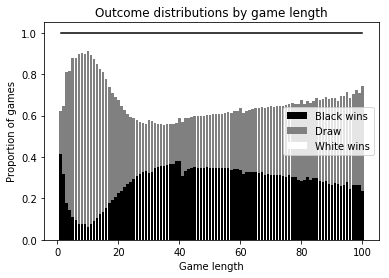

In [4]:
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title('Outcome distributions by game length')

black_bar = ax1.bar(region['length'], region['black']/region['total'], color='black')
draw_bar = ax1.bar(region['length'], region['draw']/region['total'],bottom=region['black']/region['total'], color='gray')
white_bar = ax1.bar(region['length'], region['white']/region['total'], bottom=(region['black']+region['draw'])/region['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(region['length'], a, color='black')

##### Repeat analysis for e4 and non-e4 openings
Here we load in the necessary data for repeating the analysis above when we condition on whether or not a game opens with King's Pawn (1. e4). We repeat the basic statistical analysis on both openings, and provide visualizations.

In [5]:
#Read in distributions for e4 games
e4_dists = pd.read_csv('data/dists/e4_dists.csv')
e4 = e4_dists.sort_values(by='length')
e4['total'] = e4['white'] + e4['black'] + e4['draw']

#Read in dists for non-e4 games
not_e4_dists = pd.read_csv('data/dists/not_e4_dists.csv')
ne4 = not_e4_dists.sort_values(by='length')
ne4['total'] = ne4['white'] + ne4['black'] + ne4['draw']

#Restrict data to the same region
e4_reg = e4.loc[e4['length'] >= x1]
e4_reg = e4_reg.loc[e4_reg['length'] <= x2]
ne4_reg = ne4.loc[ne4['length'] >= x1]
ne4_reg = ne4_reg.loc[ne4_reg['length'] <= x2]

#Basic statistical analysis
import math
e4_mean = round(sum(e4['total'] * e4['length'])/sum(e4['total']), 4) #the mean
e4_std = round(math.sqrt((sum(e4['total'] * (e4['length'] - e4_mean)**2)) / sum(e4['total'])), 4)
ne4_mean = round(sum(ne4['total'] * ne4['length'])/sum(ne4['total']), 4) #the mean
ne4_std = round(math.sqrt((sum(ne4['total'] * (ne4['length'] - ne4_mean)**2)) / sum(ne4['total'])), 4)

print('Mean game length of e4 games: {}'.format(e4_mean))
print('Standard deviation of e4 game length: {}'.format(e4_std))
print('Proportion of e4 games won by white: {}'.format(round(sum(e4['white'])/sum(e4['total']), 4)))
print('Proportion of e4 games won by black: {}'.format(round(sum(e4['black'])/sum(e4['total']), 4)))
print('Proportion of e4 games ending in draw: {}\n'.format(round(sum(e4['draw'])/sum(e4['total']), 4)))

print('Mean game length of non-e4 games: {}'.format(ne4_mean))
print('Standard deviation of not-e4 game length: {}'.format(ne4_std))
print('Proportion of non-e4 games won by white: {}'.format(round(sum(ne4['white'])/sum(ne4['total']), 4)))
print('Proportion of non-e4 games won by black: {}'.format(round(sum(ne4['black'])/sum(ne4['total']), 4)))
print('Proportion of non-e4 games ending in draw: {}'.format(round(sum(ne4['draw'])/sum(ne4['total']), 4)))

Mean game length of e4 games: 39.0129
Standard deviation of e4 game length: 16.0286
Proportion of e4 games won by white: 0.3897
Proportion of e4 games won by black: 0.3316
Proportion of e4 games ending in draw: 0.2787

Mean game length of non-e4 games: 39.6405
Standard deviation of not-e4 game length: 16.3469
Proportion of non-e4 games won by white: 0.3881
Proportion of non-e4 games won by black: 0.2976
Proportion of non-e4 games ending in draw: 0.3143


#### Plot length distributions of e4 and non-e4 games
Compare the length distributions to see if opening move has an effect on length distribution.

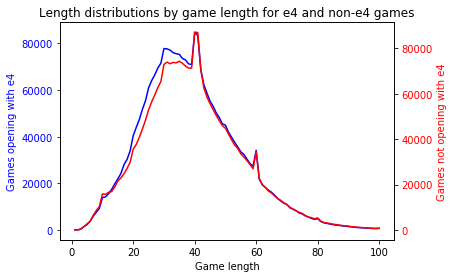

In [6]:
fig, ax1 = plt.subplots() #make a figure
ax2 = ax1.twinx()
ax1.set_title("Length distributions by game length for e4 and non-e4 games")

#Plot e4
ax1.plot(e4_reg['length'], e4_reg['total'], color='blue')
ax1.set_ylabel('Games opening with e4', color='blue')  
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xlabel('Game length') #set x-axis

#Plot non-e4
ax2.plot(ne4_reg['length'], ne4_reg['total'], color='r')
ax2.set_ylabel('Games not opening with e4', color='r')  
ax2.tick_params(axis='y', labelcolor='r')

##### Plot outcome distributions for e4 and non-e4 games
This shows the distribution of outcomes for e4 and non-e4 games.

(0, 1)

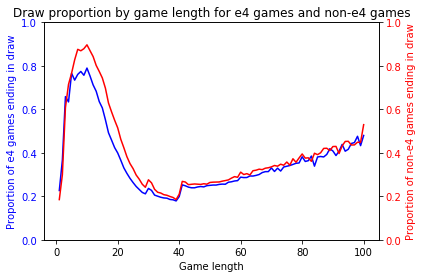

In [7]:
fig, ax1 = plt.subplots() #Make figure
ax2 = ax1.twinx()
ax1.set_title("Draw proportion by game length for e4 games and non-e4 games")

#Find draw proportions for the two openers
e4_reg_draw_prop = e4_reg['draw']/(e4_reg['white'] + e4_reg['black'] + e4_reg['draw'])
ne4_reg_draw_prop = ne4_reg['draw']/(ne4_reg['white'] + ne4_reg['black'] + ne4_reg['draw'])

#Plot e4 outcome distributions
ax1.plot(e4_reg['length'], e4_reg_draw_prop, color='blue')
ax1.set_ylabel('Proportion of e4 games ending in draw', color='blue')  
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)

ax1.set_xlabel('Game length') #Set x-axis

#Non-e4 outcome distributions
ax2.plot(ne4_reg['length'], ne4_reg_draw_prop, color='r')
ax2.set_ylabel('Proportion of non-e4 games ending in draw', color='r')  
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 1)

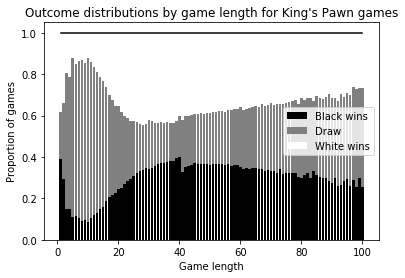

In [8]:
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for King's Pawn games")

black_bar = ax1.bar(e4_reg['length'], e4_reg['black']/e4_reg['total'], color='black')
draw_bar = ax1.bar(e4_reg['length'], e4_reg['draw']/e4_reg['total'],bottom=e4_reg['black']/e4_reg['total'], color='gray')
white_bar = ax1.bar(e4_reg['length'], e4_reg['white']/e4_reg['total'], bottom=(e4_reg['black']+e4_reg['draw'])/e4_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(e4_reg['length'], a, color='black')

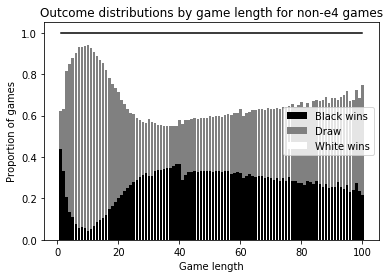

In [9]:
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title('Outcome distributions by game length for non-e4 games')

black_bar = ax1.bar(ne4_reg['length'], ne4_reg['black']/ne4_reg['total'], color='black')
draw_bar = ax1.bar(ne4_reg['length'], ne4_reg['draw']/ne4_reg['total'],bottom=ne4_reg['black']/ne4_reg['total'], color='gray')
white_bar = ax1.bar(ne4_reg['length'], ne4_reg['white']/ne4_reg['total'], bottom=(ne4_reg['black']+ne4_reg['draw'])/ne4_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(ne4_reg['length'], a, color='black')

##### Repeat analysis for top five most popular openings
Here we load in the necessary data for repeating the analysis above when we condition on the opening move. Here we will examine the top five opening moves: 1. e4, 1. d4, 1. Nf3, 1. c4, and 1. g3. Only the first four are used frequently, but we include the fifth to show how rapidly the usage frequency decreases after the four most common moves.

In [10]:
#Load csv files
d4_dists = pd.read_csv('data/dists/d4_dists.csv')
d4 = d4_dists.sort_values(by='length')
d4['total'] = d4['white'] + d4['black'] + d4['draw']

Nf3_dists = pd.read_csv('data/dists/Nf3_dists.csv')
Nf3 = Nf3_dists.sort_values(by='length')
Nf3['total'] = Nf3['white'] + Nf3['black'] + Nf3['draw']

c4_dists = pd.read_csv('data/dists/c4_dists.csv')
c4 = c4_dists.sort_values(by='length')
c4['total'] = c4['white'] + c4['black'] + c4['draw']

g3_dists = pd.read_csv('data/dists/g3_dists.csv')
g3 = g3_dists.sort_values(by='length')
g3['total'] = g3['white'] + g3['black'] + g3['draw']

In [11]:
#Restrict to our length region of interest
e4_reg = e4.loc[e4['length'] >= x1]
e4_reg = e4_reg.loc[e4_reg['length'] <= x2]
d4_reg = d4.loc[d4['length'] >= x1]
d4_reg = d4_reg.loc[d4_reg['length'] <= x2]
Nf3_reg = Nf3.loc[Nf3['length'] >= x1]
Nf3_reg = Nf3_reg.loc[Nf3_reg['length'] <= x2]
c4_reg = c4.loc[c4['length'] >= x1]
c4_reg = c4_reg.loc[c4_reg['length'] <= x2]
g3_reg = g3.loc[g3['length'] >= x1]
g3_reg = g3_reg.loc[g3_reg['length'] <= x2]

##### Simple statistical analysis for top five opening moves

In [12]:
#Basic analysis
print('Total number of e4 games: {}. Proportion of total: {}'.format(sum(e4['total']), round(sum(e4['total'])/sum(sd['total']), 4)))
print('Total number of d4 games: {}. Proportion of total: {}'.format(sum(d4['total']), round(sum(d4['total'])/sum(sd['total']), 4)))
print('Total number of Nf3 games: {}. Proportion of total: {}'.format(sum(Nf3['total']), round(sum(Nf3['total'])/sum(sd['total']), 4)))
print('Total number of c4 games: {}. Proportion of total: {}'.format(sum(c4['total']), round(sum(c4['total'])/sum(sd['total']), 4)))
print('Total number of g3 games: {}. Proportion of total: {}\n'.format(sum(g3['total']), round(sum(g3['total'])/sum(sd['total']), 4)))

e4_mean = round(sum(e4['total'] * e4['length'])/sum(e4['total']), 4) #the e4 mean
e4_std = round(math.sqrt((sum(e4['total'] * (e4['length'] - e4_mean)**2)) / sum(e4['total'])), 4)
d4_mean = round(sum(d4['total'] * d4['length'])/sum(d4['total']), 4) #the d4 mean
d4_std = round(math.sqrt((sum(d4['total'] * (d4['length'] - d4_mean)**2)) / sum(d4['total'])), 4)
Nf3_mean = round(sum(Nf3['total'] * Nf3['length'])/sum(Nf3['total']), 4) #the Nf3 mean
Nf3_std = round(math.sqrt((sum(Nf3['total'] * (Nf3['length'] - Nf3_mean)**2)) / sum(Nf3['total'])), 4)
c4_mean = round(sum(c4['total'] * c4['length'])/sum(c4['total']), 4) #the c4 mean
c4_std = round(math.sqrt((sum(c4['total'] * (c4['length'] - c4_mean)**2)) / sum(c4['total'])), 4)
g3_mean = round(sum(g3['total'] * g3['length'])/sum(g3['total']), 4) #the d4 mean
g3_std = round(math.sqrt((sum(g3['total'] * (g3['length'] - g3_mean)**2)) / sum(g3['total'])), 4)

print('Mean game length of e4 games: {}'.format(e4_mean))
print('Standard deviation of e4 game length: {}'.format(e4_std))
print('Proportion of e4 games won by white: {}'.format(round(sum(e4['white'])/sum(e4['total']), 4)))
print('Proportion of e4 games won by black: {}'.format(round(sum(e4['black'])/sum(e4['total']), 4)))
print('Proportion of e4 games ending in draw: {}\n'.format(round(sum(e4['draw'])/sum(e4['total']), 4)))

print('Mean game length of d4 games: {}'.format(d4_mean))
print('Standard deviation of d4 game length: {}'.format(d4_std))
print('Proportion of d4 games won by white: {}'.format(round(sum(d4['white'])/sum(d4['total']), 4)))
print('Proportion of d4 games won by black: {}'.format(round(sum(d4['black'])/sum(d4['total']), 4)))
print('Proportion of d4 games ending in draw: {}\n'.format(round(sum(d4['draw'])/sum(d4['total']), 4)))

print('Mean game length of Nf3 games: {}'.format(Nf3_mean))
print('Standard deviation of Nf3 game length: {}'.format(Nf3_std))
print('Proportion of Nf3 games won by white: {}'.format(round(sum(Nf3['white'])/sum(Nf3['total']), 4)))
print('Proportion of Nf3 games won by black: {}'.format(round(sum(Nf3['black'])/sum(Nf3['total']), 4)))
print('Proportion of Nf3 games ending in draw: {}\n'.format(round(sum(Nf3['draw'])/sum(Nf3['total']), 4)))

print('Mean game length of c4 games: {}'.format(c4_mean))
print('Standard deviation of c4 game length: {}'.format(c4_std))
print('Proportion of c4 games won by white: {}'.format(round(sum(c4['white'])/sum(c4['total']), 4)))
print('Proportion of c4 games won by black: {}'.format(round(sum(c4['black'])/sum(c4['total']), 4)))
print('Proportion of c4 games ending in draw: {}\n'.format(round(sum(c4['draw'])/sum(c4['total']), 4)))

print('Mean game length of g3 games: {}'.format(g3_mean))
print('Standard deviation of g3 game length: {}'.format(g3_std))
print('Proportion of g3 games won by white: {}'.format(round(sum(g3['white'])/sum(g3['total']), 4)))
print('Proportion of g3 games won by black: {}'.format(round(sum(g3['black'])/sum(g3['total']), 4)))
print('Proportion of g3 games ending in draw: {}'.format(round(sum(g3['draw'])/sum(g3['total']), 4)))

Total number of e4 games: 2832100. Proportion of total: 0.5064
Total number of d4 games: 1808488. Proportion of total: 0.3234
Total number of Nf3 games: 447025. Proportion of total: 0.0799
Total number of c4 games: 369815. Proportion of total: 0.0661
Total number of g3 games: 34842. Proportion of total: 0.0062

Mean game length of e4 games: 39.0129
Standard deviation of e4 game length: 16.0286
Proportion of e4 games won by white: 0.3897
Proportion of e4 games won by black: 0.3316
Proportion of e4 games ending in draw: 0.2787

Mean game length of d4 games: 39.6054
Standard deviation of d4 game length: 16.2792
Proportion of d4 games won by white: 0.3893
Proportion of d4 games won by black: 0.2993
Proportion of d4 games ending in draw: 0.3113

Mean game length of Nf3 games: 39.9222
Standard deviation of Nf3 game length: 16.8028
Proportion of Nf3 games won by white: 0.389
Proportion of Nf3 games won by black: 0.2714
Proportion of Nf3 games ending in draw: 0.3396

Mean game length of c4 gam

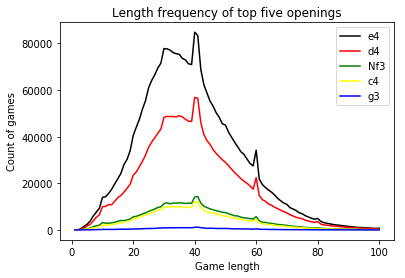

In [13]:
#Plot length frequency top five openings
fig, ax1 = plt.subplots()

e4_plot = ax1.plot(e4_reg['length'], e4_reg['total'], color='black')
d4_plot = ax1.plot(d4_reg['length'], d4_reg['total'], color='red') 
Nf3_plot = ax1.plot(Nf3_reg['length'], Nf3_reg['total'], color='green')
c4_plot = ax1.plot(c4_reg['length'], c4_reg['total'], color='yellow')
g3_plot = ax1.plot(g3_reg['length'], g3_reg['total'], color='blue') 

ax1.set_xlabel('Game length')
ax1.set_ylabel('Count of games')  

ax1.set_title('Length frequency of top five openings')

ax1.legend([e4_plot[0], d4_plot[0], Nf3_plot[0], c4_plot[0], g3_plot[0]], ['e4', 'd4', 'Nf3', 'c4', 'g3'])

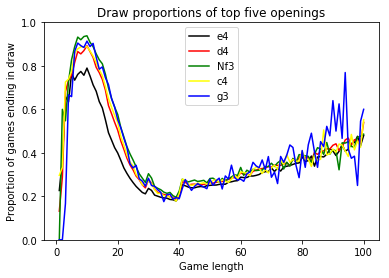

In [14]:
#Draw proportions for top five
fig, ax1 = plt.subplots()

ax1.set_xlabel('Game length')  
ax1.set_ylabel('Proportion of games ending in draw')  
ax1.set_ylim(0, 1)
ax1.set_title('Draw proportions of top five openings')

e4_reg_draw_prop = e4_reg['draw']/(e4_reg['white'] + e4_reg['black'] + e4_reg['draw'])
d4_reg_draw_prop = d4_reg['draw']/(d4_reg['white'] + d4_reg['black'] + d4_reg['draw'])
Nf3_reg_draw_prop = Nf3_reg['draw']/(Nf3_reg['white'] + Nf3_reg['black'] + Nf3_reg['draw'])
c4_reg_draw_prop = c4_reg['draw']/(c4_reg['white'] + c4_reg['black'] + c4_reg['draw'])
g3_reg_draw_prop = g3_reg['draw']/(g3_reg['white'] + g3_reg['black'] + g3_reg['draw'])


e4_draw = ax1.plot(e4_reg['length'], e4_reg_draw_prop, color='black') 
d4_draw = ax1.plot(d4_reg['length'], d4_reg_draw_prop, color='red')
Nf3_draw = ax1.plot(Nf3_reg['length'], Nf3_reg_draw_prop, color='green')
c4_draw = ax1.plot(c4_reg['length'], c4_reg_draw_prop, color='yellow')
g3_draw = ax1.plot(g3_reg['length'], g3_reg_draw_prop, color='blue')

ax1.legend([e4_draw[0], d4_draw[0], Nf3_draw[0], c4_draw[0], g3_draw[0]], ['e4', 'd4', 'Nf3', 'c4', 'g3'])

##### Repeat analysis for opening classifications

In [15]:
#Read in csv files and find total games for each classification
flank_dists = pd.read_csv('data/dists/flank_dists.csv')
flank = flank_dists.sort_values(by='length')
flank['total'] = flank['white'] + flank['black'] + flank['draw']

open_dists = pd.read_csv('data/dists/open_dists.csv')
Open = open_dists.sort_values(by='length')
Open['total'] = Open['white'] + Open['black'] + Open['draw']

sopen_dists = pd.read_csv('data/dists/sopen_dists.csv')
sopen = sopen_dists.sort_values(by='length')
sopen['total'] = sopen['white'] + sopen['black'] + sopen['draw']

closed_dists = pd.read_csv('data/dists/closed_dists.csv')
closed = closed_dists.sort_values(by='length')
closed['total'] = closed['white'] + closed['black'] + closed['draw']

indian_dists = pd.read_csv('data/dists/indian_dists.csv')
indian = indian_dists.sort_values(by='length')
indian['total'] = indian['white'] + indian['black'] + indian['draw']

print(sum(flank['total']))
print(sum(Open['total']))
print(sum(sopen['total']))
print(sum(closed['total']))
print(sum(indian['total']))

1710663
653568
2180071
520907
526473


In [16]:
#Basic analysis
print('Total number of flank games: {}. Proportion of total: {}'.format(sum(flank['total']), round(sum(flank['total'])/sum(sd['total']), 4)))
print('Total number of open games: {}. Proportion of total: {}'.format(sum(Open['total']), round(sum(Open['total'])/sum(sd['total']), 4)))
print('Total number of semi-open games: {}. Proportion of total: {}'.format(sum(sopen['total']), round(sum(sopen['total'])/sum(sd['total']), 4)))
print('Total number of closed games: {}. Proportion of total: {}'.format(sum(closed['total']), round(sum(closed['total'])/sum(sd['total']), 4)))
print('Total number of Indian games: {}. Proportion of total: {}\n'.format(sum(indian['total']), round(sum(indian['total'])/sum(sd['total']), 4)))

flank_mean = round(sum(flank['total'] * flank['length'])/sum(flank['total']), 4) #the flank mean
flank_std = round(math.sqrt((sum(flank['total'] * (flank['length'] - flank_mean)**2)) / sum(flank['total'])), 4)
Open_mean = round(sum(Open['total'] * Open['length'])/sum(Open['total']), 4) #the open mean
Open_std = round(math.sqrt((sum(Open['total'] * (Open['length'] - Open_mean)**2)) / sum(Open['total'])), 4)
sopen_mean = round(sum(sopen['total'] * sopen['length'])/sum(sopen['total']), 4) #the semi-open mean
sopen_std = round(math.sqrt((sum(sopen['total'] * (sopen['length'] - sopen_mean)**2)) / sum(sopen['total'])), 4)
closed_mean = round(sum(closed['total'] * closed['length'])/sum(closed['total']), 4) #the closed mean
closed_std = round(math.sqrt((sum(closed['total'] * (closed['length'] - closed_mean)**2)) / sum(closed['total'])), 4)
indian_mean = round(sum(indian['total'] * indian['length'])/sum(indian['total']), 4) #the indian mean
indian_std = round(math.sqrt((sum(indian['total'] * (indian['length'] - indian_mean)**2)) / sum(indian['total'])), 4)

print('Mean game length of flank games: {}'.format(flank_mean))
print('Standard deviation of flank game length: {}'.format(flank_std))
print('Proportion of flank games won by white: {}'.format(round(sum(flank['white'])/sum(flank['total']), 4)))
print('Proportion of flank games won by black: {}'.format(round(sum(flank['black'])/sum(flank['total']), 4)))
print('Proportion of flank games ending in draw: {}\n'.format(round(sum(flank['draw'])/sum(flank['total']), 4)))

print('Mean game length of open games: {}'.format(Open_mean))
print('Standard deviation of open game length: {}'.format(Open_std))
print('Proportion of open games won by white: {}'.format(round(sum(Open['white'])/sum(Open['total']), 4)))
print('Proportion of open games won by black: {}'.format(round(sum(Open['black'])/sum(Open['total']), 4)))
print('Proportion of open games ending in draw: {}\n'.format(round(sum(Open['draw'])/sum(Open['total']), 4)))

print('Mean game length of semi-open games: {}'.format(sopen_mean))
print('Standard deviation of semi-open game length: {}'.format(sopen_std))
print('Proportion of semi-open games won by white: {}'.format(round(sum(sopen['white'])/sum(sopen['total']), 4)))
print('Proportion of semi-open games won by black: {}'.format(round(sum(sopen['black'])/sum(sopen['total']), 4)))
print('Proportion of semi-open games ending in draw: {}\n'.format(round(sum(sopen['draw'])/sum(sopen['total']), 4)))

print('Mean game length of closed games: {}'.format(closed_mean))
print('Standard deviation of closed game length: {}'.format(closed_std))
print('Proportion of closed games won by white: {}'.format(round(sum(closed['white'])/sum(closed['total']), 4)))
print('Proportion of closed games won by black: {}'.format(round(sum(closed['black'])/sum(closed['total']), 4)))
print('Proportion of closed games ending in draw: {}\n'.format(round(sum(closed['draw'])/sum(closed['total']), 4)))

print('Mean game length of Indian games: {}'.format(indian_mean))
print('Standard deviation of Indian game length: {}'.format(indian_std))
print('Proportion of Indian games won by white: {}'.format(round(sum(indian['white'])/sum(indian['total']), 4)))
print('Proportion of Indian games won by black: {}'.format(round(sum(indian['black'])/sum(indian['total']), 4)))
print('Proportion of Indian games ending in draw: {}'.format(round(sum(indian['draw'])/sum(indian['total']), 4)))

Total number of flank games: 1710663. Proportion of total: 0.3059
Total number of open games: 653568. Proportion of total: 0.1169
Total number of semi-open games: 2180071. Proportion of total: 0.3898
Total number of closed games: 520907. Proportion of total: 0.0931
Total number of Indian games: 526473. Proportion of total: 0.0941

Mean game length of flank games: 39.7349
Standard deviation of flank game length: 16.3117
Proportion of flank games won by white: 0.3845
Proportion of flank games won by black: 0.3075
Proportion of flank games ending in draw: 0.308

Mean game length of open games: 38.2017
Standard deviation of open game length: 16.6113
Proportion of open games won by white: 0.4204
Proportion of open games won by black: 0.2989
Proportion of open games ending in draw: 0.2808

Mean game length of semi-open games: 39.2575
Standard deviation of semi-open game length: 15.8403
Proportion of semi-open games won by white: 0.3805
Proportion of semi-open games won by black: 0.3414
Propo

In [17]:
#Set region of interest
flank_reg = flank.loc[flank['length'] >= x1]
flank_reg = flank_reg.loc[flank_reg['length'] <= x2]
Open_reg = Open.loc[Open['length'] >= x1]
Open_reg = Open_reg.loc[Open_reg['length'] <= x2]
sopen_reg = sopen.loc[sopen['length'] >= x1]
sopen_reg = sopen_reg.loc[sopen_reg['length'] <= x2]
closed_reg = closed.loc[closed['length'] >= x1]
closed_reg = closed_reg.loc[closed_reg['length'] <= x2]
indian_reg = indian.loc[indian['length'] >= x1]
indian_reg = indian_reg.loc[indian_reg['length'] <= x2]

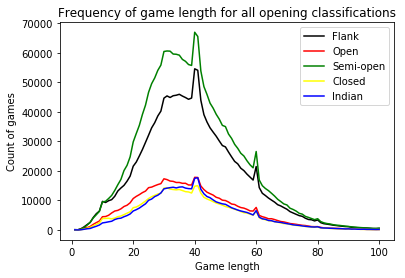

In [18]:
#Plot five opening types
fig, ax1 = plt.subplots()

flank_plot = ax1.plot(flank_reg['length'], flank_reg['total'], color='black')
Open_plot = ax1.plot(Open_reg['length'], Open_reg['total'], color='red') 
sopen_plot = ax1.plot(sopen_reg['length'], sopen_reg['total'], color='green')
closed_plot = ax1.plot(closed_reg['length'], closed_reg['total'], color='yellow')
indian_plot = ax1.plot(indian_reg['length'], indian_reg['total'], color='blue') 

ax1.set_xlabel('Game length')
ax1.set_ylabel('Count of games')  

ax1.set_title('Frequency of game length for all opening classifications')

ax1.legend([flank_plot[0], Open_plot[0], sopen_plot[0], closed_plot[0], indian_plot[0]], ['Flank', 'Open', 'Semi-open', 'Closed', 'Indian'])

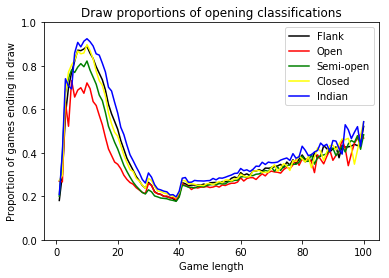

In [19]:
#Draw proportions for opening classifications
fig, ax1 = plt.subplots()

ax1.set_xlabel('Game length')  
ax1.set_ylabel('Proportion of games ending in draw')  
ax1.set_ylim(0, 1)
ax1.set_title('Draw proportions of opening classifications')

flank_reg_draw_prop = flank_reg['draw']/(flank_reg['white'] + flank_reg['black'] + flank_reg['draw'])
Open_reg_draw_prop = Open_reg['draw']/(Open_reg['white'] + Open_reg['black'] + Open_reg['draw'])
sopen_reg_draw_prop = sopen_reg['draw']/(sopen_reg['white'] + sopen_reg['black'] + sopen_reg['draw'])
closed_reg_draw_prop = closed_reg['draw']/(closed_reg['white'] + closed_reg['black'] + closed_reg['draw'])
indian_reg_draw_prop = indian_reg['draw']/(indian_reg['white'] + indian_reg['black'] + indian_reg['draw'])


flank_draw = ax1.plot(flank_reg['length'], flank_reg_draw_prop, color='black') 
Open_draw = ax1.plot(Open_reg['length'], Open_reg_draw_prop, color='red')
sopen_draw = ax1.plot(sopen_reg['length'], sopen_reg_draw_prop, color='green')
closed_draw = ax1.plot(closed_reg['length'], closed_reg_draw_prop, color='yellow')
indian_draw = ax1.plot(indian_reg['length'], indian_reg_draw_prop, color='blue')

ax1.legend([flank_draw[0], Open_draw[0], sopen_draw[0], closed_draw[0], indian_draw[0]], ['Flank', 'Open', 'Semi-open', 'Closed', 'Indian'])

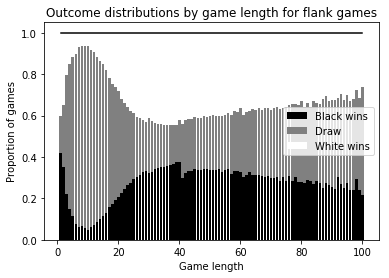

In [20]:
#Bar charts - flank
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for flank games")

black_bar = ax1.bar(flank_reg['length'], flank_reg['black']/flank_reg['total'], color='black')
draw_bar = ax1.bar(flank_reg['length'], flank_reg['draw']/flank_reg['total'],bottom=flank_reg['black']/flank_reg['total'], color='gray')
white_bar = ax1.bar(flank_reg['length'], flank_reg['white']/flank_reg['total'], bottom=(flank_reg['black']+flank_reg['draw'])/flank_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(flank_reg['length'], a, color='black')

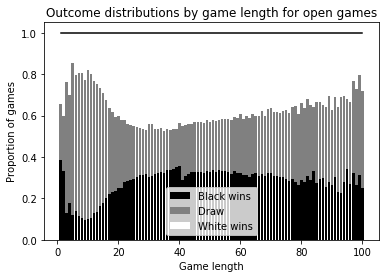

In [21]:
#Bar charts - open
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for open games")

black_bar = ax1.bar(Open_reg['length'], Open_reg['black']/Open_reg['total'], color='black')
draw_bar = ax1.bar(Open_reg['length'], Open_reg['draw']/Open_reg['total'],bottom=Open_reg['black']/Open_reg['total'], color='gray')
white_bar = ax1.bar(Open_reg['length'], Open_reg['white']/Open_reg['total'], bottom=(Open_reg['black']+Open_reg['draw'])/Open_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(Open_reg['length'], a, color='black')

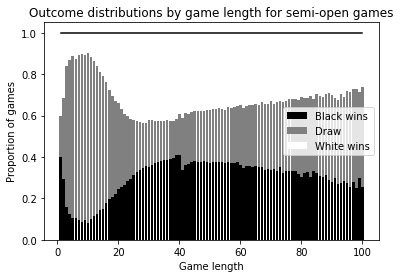

In [22]:
#Bar charts - semiopen
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for semi-open games")

black_bar = ax1.bar(sopen_reg['length'], sopen_reg['black']/sopen_reg['total'], color='black')
draw_bar = ax1.bar(sopen_reg['length'], sopen_reg['draw']/sopen_reg['total'],bottom=sopen_reg['black']/sopen_reg['total'], color='gray')
white_bar = ax1.bar(sopen_reg['length'], sopen_reg['white']/sopen_reg['total'], bottom=(sopen_reg['black']+sopen_reg['draw'])/sopen_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(sopen_reg['length'], a, color='black')

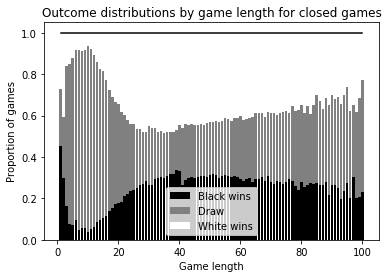

In [23]:
#Bar charts - closed
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for closed games")

black_bar = ax1.bar(closed_reg['length'], closed_reg['black']/closed_reg['total'], color='black')
draw_bar = ax1.bar(closed_reg['length'], closed_reg['draw']/closed_reg['total'],bottom=closed_reg['black']/closed_reg['total'], color='gray')
white_bar = ax1.bar(closed_reg['length'], closed_reg['white']/closed_reg['total'], bottom=(closed_reg['black']+closed_reg['draw'])/closed_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(closed_reg['length'], a, color='black')

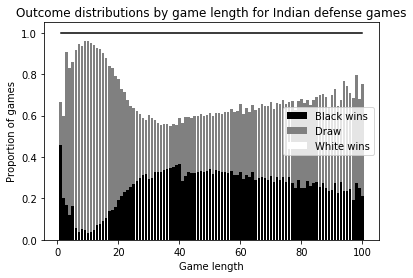

In [24]:
#Bar charts - indian
fig, ax1 = plt.subplots() #Make a figure
ax1.set_title("Outcome distributions by game length for Indian defense games")

black_bar = ax1.bar(indian_reg['length'], indian_reg['black']/indian_reg['total'], color='black')
draw_bar = ax1.bar(indian_reg['length'], indian_reg['draw']/indian_reg['total'],bottom=indian_reg['black']/indian_reg['total'], color='gray')
white_bar = ax1.bar(indian_reg['length'], indian_reg['white']/indian_reg['total'], bottom=(indian_reg['black']+indian_reg['draw'])/indian_reg['total'], color='white')

ax1.set_xlabel('Game length')
ax1.set_ylabel('Proportion of games')
ax1.legend([black_bar, draw_bar, white_bar], ['Black wins', 'Draw', 'White wins'])

a = np.arange(100)
a.fill(1)
ax1.plot(indian_reg['length'], a, color='black')

## Conclusion

We found a number of interesting associations within our data. Please see the 'Visualization and Analysis' section above to see all graphs and statisitical analysis.

First, we found that the 'tipping point' we are looking for does exist, and it is at 39 moves. Games of length 39 are most likely to have a decisive result and after that, longer games are more likely to end in a draw. This tipping point does not change when we condition on opening move or opening classification.

We also found different outcome distributions for different opening moves and classifications. e4 games are less likely to end in a draw than games employing other opening moves, but the proportion of games which white wins is not effected by opening. Instead, black is significantly more likely to win when e4 is played.

We found that for all common openings, white's win percentage hardly changes. However, black's varies substantially. For example, black wins around 33% of games beginning in e4, but only around 27% of games beginning in Nf3.

We classified each opening as flank, open, semi-open, closed, or Indian (in accordance with the Encyclopedia of Chess Openings). We found that all opening classifications see the same tipping point at 39 moves. However, game lengths and outcome distributions change significantly when we condition on opening. The average length of an open game is 38 moves, while the average length of a game where an Indian defense is employed is over 40 moves. As with opening moves, black's win percentage depends on opening classification. Black wins around 34% of semi-open games but only about 27% of closed games. White's win percentage also changes when we condition on opening classification; white wins around 42% of open games and only 37% of Indian defense games. Draws are most common in Indian defense games (~33%) while open and semi-open games are the most likely to be decisive (28% each).